#Introduction

The dataset provided by Sendy includes order details and rider metrics based on orders made on the Sendy platform. The challenge is to predict the estimated time of arrival for orders- from pick-up to drop-off.

Sendy provides an API as well as a web and mobile application platform to link customers who have delivery needs with vetted transporters. The customers select their vehicle of choice, get their price quote upfront and pay using various payment options. The system optimises the route, looks for the closest available riders and dispatches the orders in the most efficient way.

The training dataset provided here is a subset of over 20,000 orders and only includes direct orders (i.e. Sendy “express” orders) with bikes in Nairobi. All data in this subset have been fully anonymized while preserving the distribution.

###The approach followed in this challenge is outlined below:

*   Visualize and explore the dataset
*   Select which features to use
*   Train prediction models
*   Evaluate the trained models
*   Select the best performing model
*   submit results




##Import libraries and upload data


In [0]:
# Importing libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
%matplotlib inline

# should these be here or in the body of the code? - PEP8
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# avoid pd warnings 
import warnings
warnings.filterwarnings("ignore")

# upload data
Test = pd.read_csv('Test.csv')
Train = pd.read_csv('Train.csv')
Riders = pd.read_csv('Riders.csv')
Sub = pd.read_csv('SampleSubmission.csv')

# merge drivers's informations with the train and test datasets
Train = Train.merge(Riders, on='Rider Id', how='left')
Test = Test.merge(Riders, on='Rider Id', how='left')


#Exploratory Data Analysis

## Summary Statistics 

In this section the data types and the summary statistics of the given variables will be explored.
 
The data types and number of entries of each column will be determined first.

In [610]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21201 entries, 0 to 21200
Data columns (total 33 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Order No                                   21201 non-null  object 
 1   User Id                                    21201 non-null  object 
 2   Vehicle Type                               21201 non-null  object 
 3   Platform Type                              21201 non-null  int64  
 4   Personal or Business                       21201 non-null  object 
 5   Placement - Day of Month                   21201 non-null  int64  
 6   Placement - Weekday (Mo = 1)               21201 non-null  int64  
 7   Placement - Time                           21201 non-null  object 
 8   Confirmation - Day of Month                21201 non-null  int64  
 9   Confirmation - Weekday (Mo = 1)            21201 non-null  int64  
 10  Confirmation - Time   

Observations:

*   The 'Temperature' and 'Percipitation' columns contain Null values.
*   There are a few 'object' type columns that will either need to be converted or dropped.


Now a table showcasing the summary statistics of the data will be conscidered.


In [611]:
Train.describe().T


,count,mean,std,min,25%,50%,75%,max
Platform Type,21201.0,2.752182,0.625178,1.000000,3.000000,3.000000,3.000000,4.000000
Placement - Day of Month,21201.0,15.653696,8.798916,1.000000,8.000000,15.000000,23.000000,31.000000
Placement - Weekday (Mo = 1),21201.0,3.240083,1.567295,1.000000,2.000000,3.000000,5.000000,7.000000
Confirmation - Day of Month,21201.0,15.653837,8.798886,1.000000,8.000000,15.000000,23.000000,31.000000
Confirmation - Weekday (Mo = 1),21201.0,3.240225,1.567228,1.000000,2.000000,3.000000,5.000000,7.000000
Arrival at Pickup - Day of Month,21201.0,15.653837,8.798886,1.000000,8.000000,15.000000,23.000000,31.000000
Arrival at Pickup - Weekday (Mo = 1),21201.0,3.240225,1.567228,1.000000,2.000000,3.000000,5.000000,7.000000
Pickup - Day of Month,21201.0,15.653837,8.798886,1.000000,8.000000,15.000000,23.000000,31.000000
Pickup - Weekday (Mo = 1),21201.0,3.240225,1.567228,1.000000,2.000000,3.000000,5.000000,7.000000
Arrival at Destination - Day of Month,21201.0,15.653837,8.798886,1.000000,8.000000,15.000000,23.000000,31.000000


Observations:

*   The 'Platform Type' column only contains the numbers 1 - 4, which corresponds to the different platforms customers can use to place their orders.
*   The average distance travelled to deliver an order is 9.5km with a std of 5.7km.
* The arverage Temperature at the time of delivery is 23 degrees celcius with a std of 3.2.
* Based on the means and standard deviations of different columns, the dataset will need to be standardized.


###Distribution of Delivery times

A histogram of delivery times as well as the outlier threshold will be plotted to viuslize the distribution of the delivery times *(the variable we're trying to predict)*.

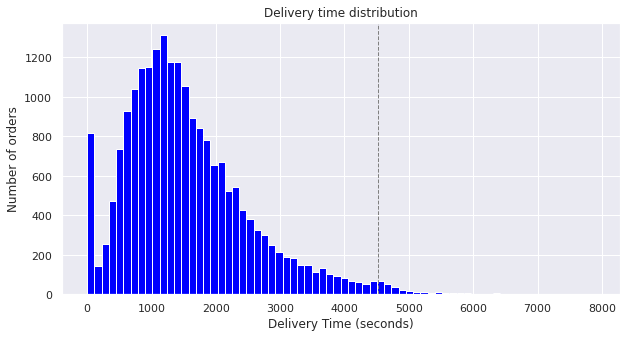

In [612]:
mu = Train.iloc[:,28].mean()
sd = Train.iloc[:,28].std()
li = mu + 3*sd

sns.set()
_ = plt.figure(figsize = (10,5))
_ = plt.hist(Train.iloc[:,28], bins = 70, color = 'blue')
_ = plt.title('Delivery time distribution')
_ = plt.xlabel('Delivery Time (seconds)')
_ = plt.ylabel('Number of orders')
_ = plt.axvline(li, color = 'gray', linestyle = 'dashed', linewidth = 1)
plt.show()

Observations: 

From the plot above it’s clear that the delivery times are skewed, with the majority of orders being delivered in about 16 minutes 

The grey dotted line above indicates the threshold for existance of outliers (measured by the presence of values 3 standard deviation away from the mean.)

It could be useful to visualize the distribution for all the predictor variables in the data set.



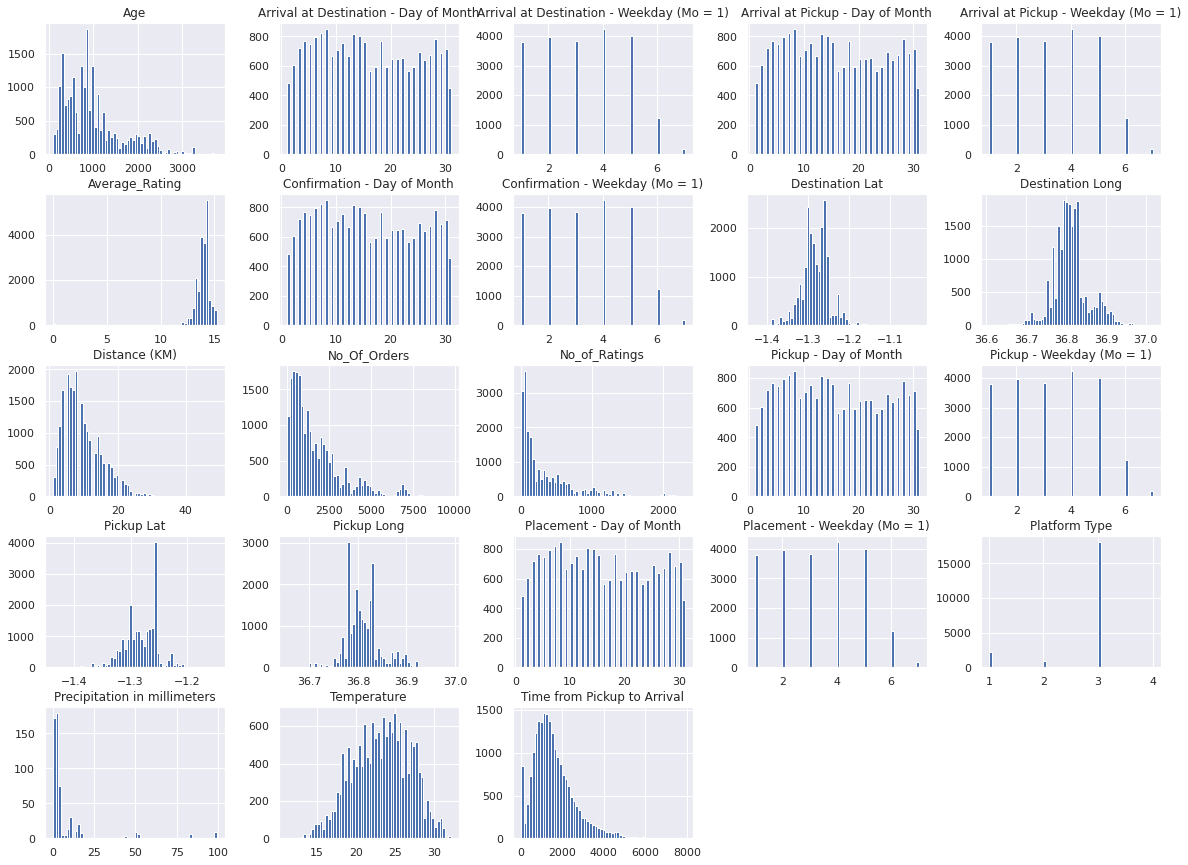

In [613]:
sns.set()
Train.hist(bins = 60, figsize = (20,15))
plt.show()

Observations:


*   Majority of the orders are placed using platform 3 and only a tiny portion using platform 4
*   Weekends are not as busy compared to weekdays 
* Most orders are delivered within a 10km radius
* No obvious trend for day of month
* Most Temperatures fall between 20 and 27 degrees celcius
* The average driver rating is between 13 and 15 with vary little varience 



## Exploring the relationship between delivery time and a few features

The relationship between delivery time and distance travelled is plotted first


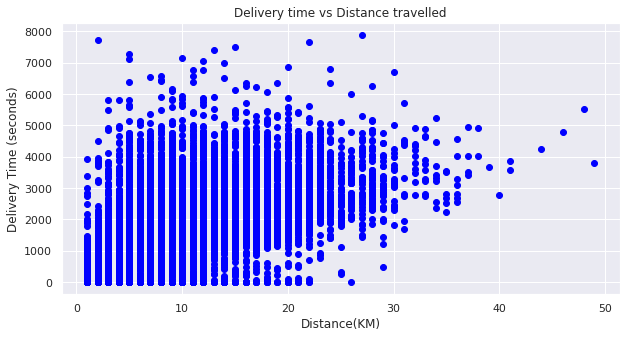

In [614]:
sns.set()
_ = plt.figure(figsize = (10,5))
_ = plt.scatter(Train.iloc[:,20],Train.iloc[:,28], color = 'blue')
_ = plt.title('Delivery time vs Distance travelled')
_ = plt.xlabel('Distance(KM)')
_ = plt.ylabel('Delivery Time (seconds)')
plt.show()

Observations:

The relationship between distance and delivery time is intuitive and seems 

*   The relationship between distance and delivery time is intuitive and seems linear even for outliers


Next the relationship between the day of the week that orders are placed and the delivery times is visualized using a violin plot

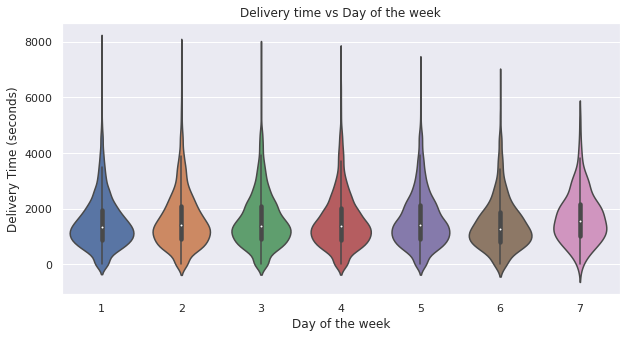

In [615]:
sns.set()
_ = plt.figure(figsize = (10,5))
_ = sns.violinplot(x = Train.iloc[:,12], y = Train.iloc[:,28], data = Train )
_ = plt.title('Delivery time vs Day of the week')
_ = plt.xlabel('Day of the week')
_ = plt.ylabel('Delivery Time (seconds)')


Observations:
 

*   Deliveries are generally faster over weekends, with the fastest delivery times on Sundays. This could possibly be due to drivers experiencing less traffic over weekends 


# Checking for Multicolinearity

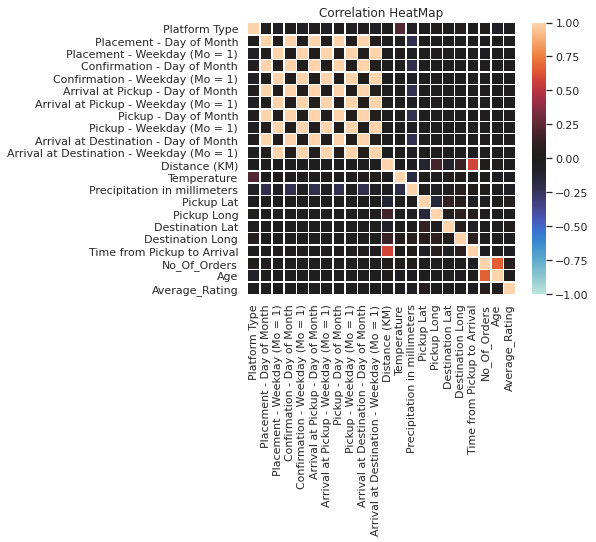

In [616]:
features = Train.iloc[:,:-1]
targets = Train.iloc[:,-1]

#creating pairwise correlation of columns using Pearson's R,
corr = features.corr(method='pearson') 

#plotting the correlation coefficients on a seasborn heatmap matrix
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(corr, xticklabels=corr.columns, 
            yticklabels=corr.columns, ax=ax, linewidths=.5, 
            vmin = -1, vmax=1, center=0)

plt.title('Correlation HeatMap')
plt.show()


# Converting data types and Dealing with missing values

In [0]:
# Replacing Null values in the temperature column with the average value - train and test set
imputer_temp = SimpleImputer(missing_values = np.NaN, strategy = 'mean')
imputer_temp_1 = SimpleImputer(missing_values = np.NaN, strategy = 'mean')

from sklearn.impute import SimpleImputer
imputer_temp.fit(Train.iloc[:,20:22])
Train.iloc[:,20:22] = imputer_temp.transform(Train.iloc[:,20:22])

imputer_temp_1.fit(Train.iloc[:,17:19])
Test.iloc[:,17:19] = imputer_temp_1.transform(Test.iloc[:,17:19])

# Replacing the Null values in the precipitation column with 0 - train and test set 
imputer_prec = SimpleImputer(missing_values = np.NaN, strategy = 'constant', fill_value = 0)
imputer_prec_1 = SimpleImputer(missing_values = np.NaN, strategy = 'constant', fill_value = 0)

imputer_prec.fit(Train.iloc[:,22:])
Train.iloc[:,22:] = imputer_prec.transform(Train.iloc[:,22:])

imputer_prec_1.fit(Test.iloc[:,19:22])
Test.iloc[:,19:22] = imputer_prec_1.transform(Test.iloc[:,19:22])        

# Feature Engineering
The following new features will be created using the existing information to better catagorise data points which will help improve the model predictions:


*   Temperature = pleasant/unpleasant 
*   Age of rider = experience (inexperienced, average, experienced)
*   day of the week = weekend/weekday
*   Time of day = AM/PM

###Creating the updated Temperature feature 
Creating a function that will interperate the temperature as either pleasant or unpleasant, where extreme conditions are seen as unpleasant. The function will be applied to both the training and test data 



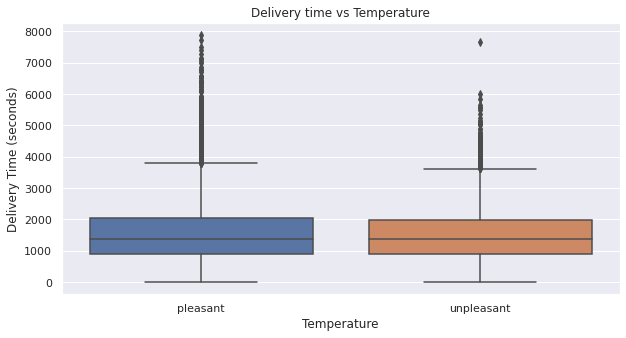

In [618]:
def conv_temp(df):
    type_of_temp = []

    for t in df['Temperature']:
        if (t < 18.0 or t > 28.0):  
           type_of_temp.append('unpleasant')
        else: type_of_temp.append('pleasant')
    df['Temperature'] = type_of_temp
    return

conv_temp(Train) 
conv_temp(Test)

sns.set()
_ = plt.figure(figsize = (10,5))
_ = sns.boxplot(x = Train['Temperature'], y = Train.iloc[:,28], data = Train )
_ = plt.title('Delivery time vs Temperature')
_ = plt.xlabel('Temperature')
_ = plt.ylabel('Delivery Time (seconds)')


Observations:

*   More outliers and slightly longer delivery times when the weather is pleasant




### Converting the age of the driver into an experience feature

The experience level of the drivers will be divided into 3 categories: inexperinced, average and experienced based on the quartiles 


In [619]:
Riders.describe()

,No_Of_Orders,Age,Average_Rating,No_of_Ratings
count,960.000000,960.000000,960.000000,960.000000
mean,1864.851042,1200.234375,13.412604,427.983333
std,1880.337785,810.930171,2.675794,486.957931
min,2.000000,96.000000,0.000000,0.000000
25%,261.750000,478.250000,13.500000,30.000000
50%,1475.500000,1021.000000,14.000000,223.000000
75%,2847.250000,1891.500000,14.300000,678.750000
max,9756.000000,3764.000000,15.200000,2298.000000


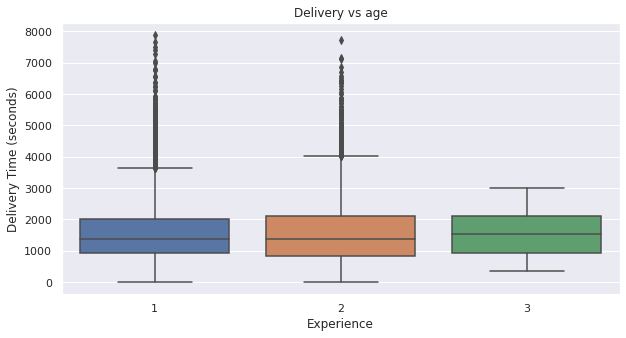

In [620]:
def experience(df):
  exp = []  
  for age in df['Age']:
    if (age < 1021):
      exp.append(1)
    elif (age > 1021 & age < 1891.5):
      exp.append(2)
    else: exp.append(3)
  df['Age'] = exp
  return

experience(Train)
experience(Test)

sns.set()
_ = plt.figure(figsize = (10,5))
_ = sns.boxplot(x = Train['Age'], y = Train.iloc[:,28], data = Train )
_ = plt.title('Delivery vs age')
_ = plt.xlabel('Experience')
_ = plt.ylabel('Delivery Time (seconds)')


Observations:


*   Less experienced drivers have longer delivery times with more outliers
*   More experienced drivers have less varience and outliers in terms of their delivery times 




### Converting the day of the week into a weekday or weekend feature

days 1 - 5 are weekdays, while 6 and 7 are weekeds



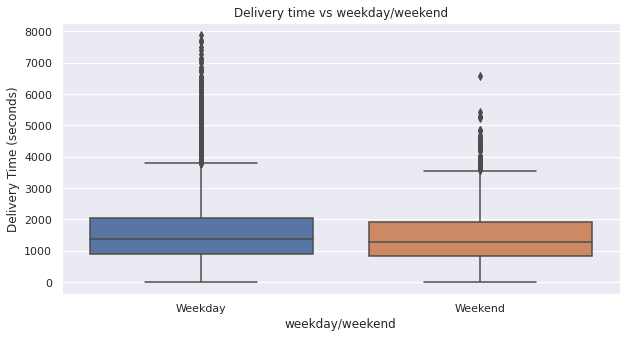

In [621]:
Train['Pickup - Weekday (Mo = 1)'] = np.where(Train['Pickup - Weekday (Mo = 1)']<6, 'Weekday', 'Weekend')
Test['Pickup - Weekday (Mo = 1)'] = np.where(Test['Pickup - Weekday (Mo = 1)']<6, 'Weekday', 'Weekend')

sns.set()
_ = plt.figure(figsize = (10,5))
_ = sns.boxplot(x = Train['Pickup - Weekday (Mo = 1)'], y = Train.iloc[:,28], data = Train )
_ = plt.title('Delivery time vs weekday/weekend')
_ = plt.xlabel('weekday/weekend')
_ = plt.ylabel('Delivery Time (seconds)')


Observations:

*   Deliveries are generally faster over weekends. This could possibly be due to drivers experiencing less traffic over weekends 
*   More outliers during the week



### Coverting the time of pickup feature into a time of day feature

creating a function that will categorise the time of day into morning, afternoon and evening for both the train and test data


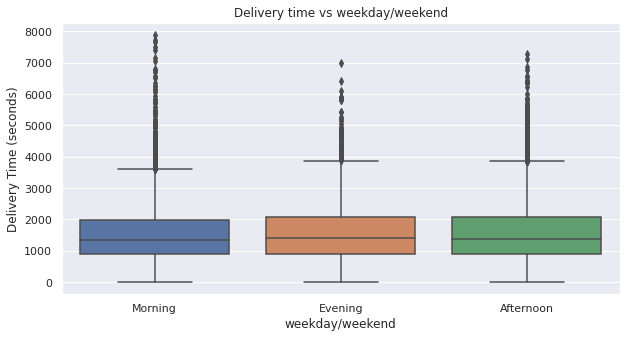

In [622]:
Train['Pickup - Time'] = pd.to_datetime(Train['Pickup - Time'])
Test['Pickup - Time'] = pd.to_datetime(Test['Pickup - Time'])

# Extracting the hour from the time for both the traing and testing datasets
Train['Pickup - Time'] = Train['Pickup - Time'].dt.hour 
Test['Pickup - Time'] = Test['Pickup - Time'].dt.hour

def day_time(df):
        Time_of_day = [] 
        for hour in df['Pickup - Time']:
            if (hour<12):
                Time_of_day.append('Morning')
            elif (hour>12 & hour<17):
                Time_of_day.append('Afternoon')
            else:
                Time_of_day.append('Evening')
        df['Pickup - Time'] = Time_of_day 
        return 

day_time(Train)
day_time(Test)

sns.set()
_ = plt.figure(figsize = (10,5))
_ = sns.boxplot(x = Train['Pickup - Time'], y = Train.iloc[:,28], data = Train )
_ = plt.title('Delivery time vs weekday/weekend')
_ = plt.xlabel('weekday/weekend')
_ = plt.ylabel('Delivery Time (seconds)')

Observations:


*  More outliers are observed in the mornings, leaning towards longer delivery times in the morining compared to afternoon and evenings


# Drop columns containing repeated or unnecessary information

In [632]:
# Train data
Train_lin = Train.copy()
Train_lin.drop('Rider Id', axis=1, inplace=True)
Train_lin.drop('Pickup Long', axis=1, inplace=True)
Train_lin.drop('Pickup Lat', axis=1, inplace=True)
Train_lin.drop('Destination Lat', axis=1, inplace=True)
Train_lin.drop('Destination Long', axis=1, inplace=True)
Train_lin.drop('Order No', axis=1, inplace=True)
Train_lin.drop('User Id', axis=1, inplace=True)
Train_lin.drop('Vehicle Type', axis=1, inplace=True)
Train_lin.drop('Placement - Day of Month', axis=1, inplace=True)
Train_lin.drop('Placement - Weekday (Mo = 1)', axis=1, inplace=True)
Train_lin.drop('Placement - Time', axis=1, inplace=True)
Train_lin.drop('Confirmation - Day of Month', axis=1, inplace=True)
Train_lin.drop('Confirmation - Weekday (Mo = 1)', axis=1, inplace=True)
Train_lin.drop('Confirmation - Time', axis=1, inplace=True)
Train_lin.drop('Arrival at Pickup - Day of Month', axis=1, inplace=True)
Train_lin.drop('Arrival at Pickup - Weekday (Mo = 1)', axis=1, inplace=True)
Train_lin.drop('Arrival at Pickup - Time', axis=1, inplace=True)
Train_lin.drop('Arrival at Destination - Day of Month', axis=1, inplace=True)
Train_lin.drop('Arrival at Destination - Weekday (Mo = 1)', axis=1, inplace=True)
Train_lin.drop('Arrival at Destination - Time', axis=1, inplace=True)
Train_lin.drop('Pickup - Day of Month', axis=1, inplace=True)
Train_lin.drop('No_of_Ratings', axis = 1, inplace = True)
Train_lin.drop('No_Of_Orders', axis = 1, inplace = True)


# Test data
Test_lin = Test.copy()
Test_lin.drop('Rider Id', axis=1, inplace=True)
Test_lin.drop('Pickup Long', axis=1, inplace=True)
Test_lin.drop('Pickup Lat', axis=1, inplace=True)
Test_lin.drop('Destination Lat', axis=1, inplace=True)
Test_lin.drop('Destination Long', axis=1, inplace=True)
Test_lin.drop('Order No', axis=1, inplace=True)
Test_lin.drop('User Id', axis=1, inplace=True)
Test_lin.drop('Vehicle Type', axis=1, inplace=True)
Test_lin.drop('Placement - Day of Month', axis=1, inplace=True)
Test_lin.drop('Placement - Weekday (Mo = 1)', axis=1, inplace=True)
Test_lin.drop('Placement - Time', axis=1, inplace=True)
Test_lin.drop('Confirmation - Day of Month', axis=1, inplace=True)
Test_lin.drop('Confirmation - Weekday (Mo = 1)', axis=1, inplace=True)
Test_lin.drop('Confirmation - Time', axis=1, inplace=True)
Test_lin.drop('Arrival at Pickup - Day of Month', axis=1, inplace=True)
Test_lin.drop('Arrival at Pickup - Weekday (Mo = 1)', axis=1, inplace=True)
Test_lin.drop('Arrival at Pickup - Time', axis=1, inplace=True)
Test_lin.drop('Pickup - Day of Month', axis=1, inplace=True)
Test_lin.drop('No_of_Ratings', axis = 1, inplace = True)
Test_lin.drop('No_Of_Orders', axis = 1, inplace = True)

Train_lin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21201 entries, 0 to 21200
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Platform Type                 21201 non-null  int64  
 1   Personal or Business          21201 non-null  object 
 2   Pickup - Weekday (Mo = 1)     21201 non-null  object 
 3   Pickup - Time                 21201 non-null  object 
 4   Distance (KM)                 21201 non-null  float64
 5   Temperature                   21201 non-null  object 
 6   Precipitation in millimeters  21201 non-null  float64
 7   Time from Pickup to Arrival   21201 non-null  int64  
 8   Age                           21201 non-null  int64  
 9   Average_Rating                21201 non-null  float64
dtypes: float64(3), int64(3), object(4)
memory usage: 1.8+ MB


# Encode Categorical data

* Temperature
* Personal or Business
* Weekday
* Time of day








In [653]:
# Create a dictionaries
dic = {'Personal': 0,'Business': 1} 

# use the dictionaries to modify the columns with 'lightswitch' features 
Train_lin['Personal or Business'].replace(dic, inplace=True) 
Test_lin['Personal or Business'].replace(dic, inplace=True)  

df_dummies_train = pd.get_dummies(Train_lin, drop_first=True)
df_dummies_test = pd.get_dummies(Test_lin, drop_first=True)

df_dummies_train.head()



,Platform Type,Personal or Business,Distance (KM),Precipitation in millimeters,Time from Pickup to Arrival,Age,Average_Rating,Pickup - Weekday (Mo = 1)_Weekend,Pickup - Time_Evening,Pickup - Time_Morning,Temperature_unpleasant
0,3,1,4.0,0.0,745,2,13.8,0,0,1,0
1,3,0,16.0,0.0,1993,1,13.6,0,0,1,0
2,3,1,3.0,0.0,455,1,12.5,0,1,0,0
3,3,1,9.0,0.0,1341,1,14.5,0,0,1,0
4,1,0,9.0,0.0,1214,1,14.1,0,0,1,1


# Split Train data into predictors and respons variables

afterwards, the predictors will be standardized

In [654]:
X = df_dummies_train.copy()
X.drop('Time from Pickup to Arrival', axis = 1, inplace = True)

X.head()

,Platform Type,Personal or Business,Distance (KM),Precipitation in millimeters,Age,Average_Rating,Pickup - Weekday (Mo = 1)_Weekend,Pickup - Time_Evening,Pickup - Time_Morning,Temperature_unpleasant
0,3,1,4.0,0.0,2,13.8,0,0,1,0
1,3,0,16.0,0.0,1,13.6,0,0,1,0
2,3,1,3.0,0.0,1,12.5,0,1,0,0
3,3,1,9.0,0.0,1,14.5,0,0,1,0
4,1,0,9.0,0.0,1,14.1,0,0,1,1


In [655]:
y = df_dummies_train['Time from Pickup to Arrival']
print(y)

0         745
1        1993
2         455
3        1341
4        1214
         ... 
21196       9
21197     770
21198    2953
21199    1380
21200    2128
Name: Time from Pickup to Arrival, Length: 21201, dtype: int64


In [656]:
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
X_scaled = scalar.fit_transform(X)
X_std = pd.DataFrame(X_scaled, columns=X.columns)

X_std.head()

print(y)

0         745
1        1993
2         455
3        1341
4        1214
         ... 
21196       9
21197     770
21198    2953
21199    1380
21200    2128
Name: Time from Pickup to Arrival, Length: 21201, dtype: int64


# Building the different models

* Multiple linear regression
* Decision Tree Regression
* Random Forest Regression





In [657]:

# splitting the data in a test and train set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Building a linear regression model 
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train,y_train)

# Building a decision tree regression model 
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)

# Building a random forest regression model 
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators = 500)
forest.fit(X_test, y_test)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

#Calculating RMSE

In [658]:
from sklearn.metrics import mean_squared_error

# Multiple linear regression
y_pred_test = lm.predict(X_test)
y_pred_train = lm.predict(X_train)
rmse_test = round(np.sqrt(mean_squared_error(y_test, y_pred_test)),2)
rmse_train = round(np.sqrt(mean_squared_error(y_train, y_pred_train)),2)

# Decision Tree regression
y_pred_test_tree = tree.predict(X_test)
y_pred_train_tree = tree.predict(X_train)
rmse_test_tree = round(np.sqrt(mean_squared_error(y_test, y_pred_test_tree)),2)
rmse_train_tree = round(np.sqrt(mean_squared_error(y_train, y_pred_train_tree)),2)

# Random forrest regression 
y_pred_test_forest = forest.predict(X_test)
y_pred_train_forest = forest.predict(X_train)
rmse_test_forest = round(np.sqrt(mean_squared_error(y_test, y_pred_test_forest)),2)
rmse_train_forest = round(np.sqrt(mean_squared_error(y_train, y_pred_train_forest)),2)

data = {'Regression model':  ['Mulitiple linear', 'Decision Tree', 'Random Forest'],
        'RMSE Training': [rmse_train, rmse_train_tree, rmse_train_forest],
        'RMSE Testing' : [rmse_test, rmse_test_tree, rmse_test_forest]
        }

df = pd.DataFrame (data, columns = ['Regression model', 'RMSE Training', 'RMSE Testing'])
df.head()


,Regression model,RMSE Training,RMSE Testing
0,Mulitiple linear,802.90,788.79
1,Decision Tree,613.93,933.29
2,Random Forest,881.76,499.02


In [661]:

# Multiple linear regression
y_pred_lin = lm.predict(df_dummies_test)

# Decision Tree regression
y_pred_tree = tree.predict(df_dummies_test)

# Random forrest regression 
y_pred_forest = forest.predict(df_dummies_test)

# Submission
sb_dataframe = Test.iloc[:,:3]
sb_dataframe['Time from pick up to arrival 1'] = y_pred_forest
sb_dataframe.drop('User Id', inplace = True, axis = 1)
sb_dataframe.drop('Vehicle Type', inplace = True, axis = 1)

print(sb_dataframe)
sb_dataframe.to_csv('submission_random_forest.csv', index = False)



            Order No  Time from pick up to arrival 1
0     Order_No_19248                      633.949105
1     Order_No_12736                     1015.921367
2       Order_No_768                     1126.668519
3     Order_No_15332                     1574.012591
4     Order_No_21373                     1228.877458
...              ...                             ...
7063   Order_No_3612                     1126.668519
7064   Order_No_7657                     3036.551129
7065   Order_No_1969                     1178.612445
7066  Order_No_10591                     2416.757000
7067   Order_No_1603                     1332.289321

[7068 rows x 2 columns]


In [630]:
print(Sub)

            Order_No  Time from Pickup to Arrival
0     Order_No_19248                        567.0
1     Order_No_12736                       4903.0
2       Order_No_768                       5649.0
3     Order_No_15332                          NaN
4     Order_No_21373                          NaN
...              ...                          ...
7063   Order_No_3612                          NaN
7064   Order_No_7657                          NaN
7065   Order_No_1969                          NaN
7066  Order_No_10591                          NaN
7067   Order_No_1603                          NaN

[7068 rows x 2 columns]
